# Importing Modules

In [1]:
from utils import load_data
import yaml
from pharmbio.cp import plotting
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import warnings
from models import ConformalRegressor
warnings.filterwarnings("ignore")

In [2]:
with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

# Defining Parameters

In [3]:
method = 'fingerprints'  # 'descriptors', or 'fingerprints' or 'graph'
figerprint = 'morgan'  # 'morgan' or 'rdk' or 'atom pair' or 'topological torsion'
threshold = 'median'  # 'mean' or 'median' or 'max' or 'min' or 'std' or float value
embedding_size = 128  # any integer value

# Loading Data

In [4]:
loader = load_data(
    loader_type=method,
    task='regression',
    fingerprint_type=figerprint,
    threshold=threshold,
    test_size=config['test_size'],
    calibration_size=config['calibration_size'],
    descriptors=None,
    embedding_size=embedding_size,
    apply_dim_reduction=False,
    dim_reduction_method='pca',
    n_components=20,
    top_k_features=20
    )

In [5]:
loader.dataset.head()

,morgan_descriptor_1,morgan_descriptor_2,morgan_descriptor_3,morgan_descriptor_4,morgan_descriptor_5,morgan_descriptor_6,morgan_descriptor_7,morgan_descriptor_8,morgan_descriptor_9,morgan_descriptor_10,...,morgan_descriptor_120,morgan_descriptor_121,morgan_descriptor_122,morgan_descriptor_123,morgan_descriptor_124,morgan_descriptor_125,morgan_descriptor_126,morgan_descriptor_127,morgan_descriptor_128,target
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,8.045757
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,7.045757
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,7.853872
3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,6.301030
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,8.301030


# Splitting Dataset

In [6]:
splits = loader.split()
X_train, X_cal, X_test = splits['X_train'], splits['X_cal'], splits['X_test']
y_train, y_cal, y_test = splits['y_train'], splits['y_cal'], splits['y_test']

# Training Model

In [7]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [8]:
names = [
    "AdaBoost",
    "Random Forest",
    "Gaussian Process",
    "KNN",
    "MLP",
    "Linear SVR",
    "RBF SVR",
    "Decision Tree",
    "Linear Regression",
    "Lasso",
    "Ridge"
]

In [9]:
regressors = [
    AdaBoostRegressor(random_state=42),
    RandomForestRegressor(max_depth=5, n_estimators=100, max_features=1, random_state=42),
    GaussianProcessRegressor(1.0 * RBF(1.0), random_state=42),
    KNeighborsRegressor(3),
    MLPRegressor(alpha=1, max_iter=1000, random_state=42),
    SVR(kernel="linear", C=0.025),
    SVR(gamma=2, C=1),
    DecisionTreeRegressor(max_depth=5, random_state=42),
    LinearRegression(),
    Lasso(random_state=42),
    Ridge(random_state=42)
]

In [10]:
regressors_objects = dict(zip(names, regressors))

In [11]:
rgr = ConformalRegressor(base_estimator=regressors_objects['RBF SVR'], confidence=0.95).fit(X_train, y_train)
rgr.calibrate(X_cal, y_cal)
rgr.evaluate(X_test, y_test)

,confidence,coverage,width_mean,width_median,width_sd,validity_score,efficiency_score,mse,rmse,mae,r2
0,0.95,0.957616,4.709133,4.709133,7.245941e-16,0.992384,0.212353,1.809464,1.345163,0.885301,0.041131


# Visualization

In [12]:
width_mean = []
width_median = []
width_std = []
significance_level = np.arange(0.01, 1, 0.05)

In [13]:
for alpha in tqdm(significance_level):
    rgr = ConformalRegressor(base_estimator=regressors_objects['Random Forest'], confidence=1 - alpha).fit(X_train, y_train)
    rgr.calibrate(X_cal, y_cal)
    evaluation = rgr.evaluate(X_test, y_test)
    width_mean.append(evaluation['width_mean'].values[0])
    width_median.append(evaluation['width_median'].values[0])
    width_std.append(evaluation['width_sd'].values[0])

100%|██████████| 20/20 [00:01<00:00, 11.94it/s]


In [14]:
width_std = np.array(width_std)
width_mean = np.array(width_mean)
width_median = np.array(width_median)

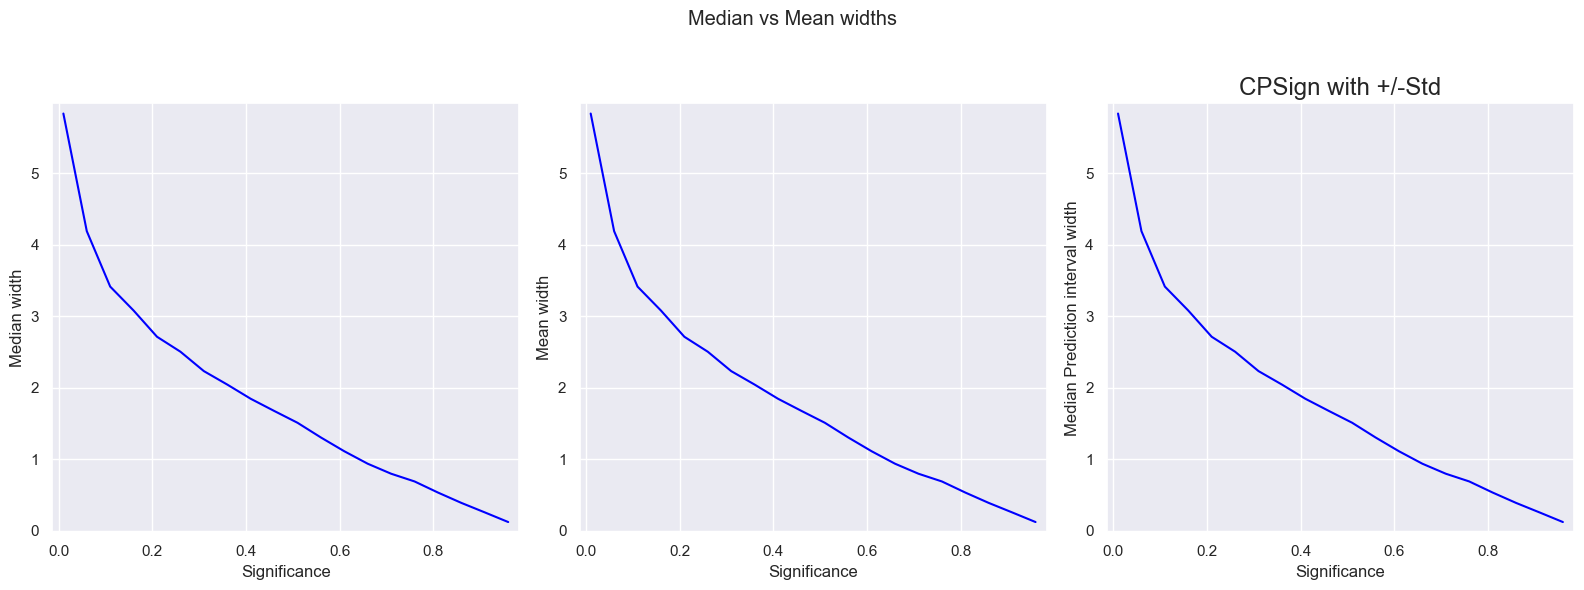

In [15]:
fig, axes = plt.subplots(1,3,figsize=(16,6))

plotting.plot_pred_widths(significance_level, width_median, ax=axes[0],y_label='Median width')
plotting.plot_pred_widths(significance_level, width_mean, ax=axes[1], y_label='Mean width')
plotting.plot_pred_widths(significance_level, width_median, width_std, title='CPSign with +/-Std', ax=axes[2])

fig.suptitle('Median vs Mean widths')
fig.tight_layout(rect=[0, 0, 1, 0.96])

In [16]:
random_indices = np.random.randint(0, len(y_test), 30)

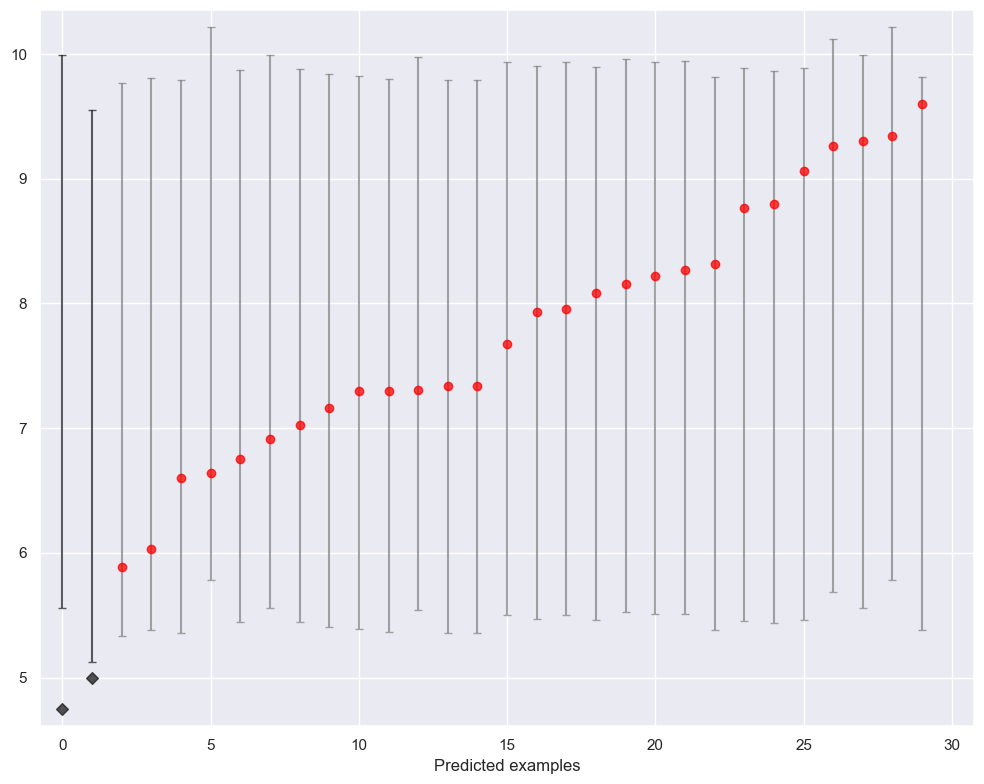

In [17]:

figure = plotting.plot_pred_intervals(
    y_test.values[random_indices],
    rgr.wrapper.predict_int(X_test)[random_indices],
    correct_color='red',
    incorrect_color = 'k',
    incorrect_ci='k',
    incorrect_marker='D'
    )